# Zendo 交互式游戏测试平台

这个 Notebook 是一个可以灵活运行单局游戏并进行全面分析的测试平台。

### 功能：
1. **运行单局游戏**：指定 Game ID，完整运行一局 Zendo 游戏
2. **实时输出**：显示每一轮的详细信息
   - 每个假设的准确率
   - 选择检验的公案编号
   - 检验结果（Pass/Fail）
3. **可视化分析**：游戏结束后自动生成分析图表
   - 准确率演变曲线
   - 假设多样性分析
   - 稳定性/变化率
   - 预测热力图

### 使用方法：
在配置区域设置 `GAME_ID`，然后依次运行所有 Cell。


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 导入游戏核心模块
from game import RuleEngine
from world import KoanAtlas
from physics import IsingModel
from dynamics import FastSolver, DPP, SlowLearner
from config import Config

# --- 配置区域 ---
GAME_ID = 2  # <--- 在这里修改你想运行的游戏编号 (1-9)
# ----------------

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print(f"✅ 已导入所有模块，准备运行 Game {GAME_ID}")


✅ 已导入所有模块，准备运行 Game 2


In [2]:
# 初始化游戏系统
print("正在初始化游戏系统...")

atlas = KoanAtlas()
rule_engine = RuleEngine(atlas)
physics = IsingModel(atlas.num_koans)
solver = FastSolver()
dpp = DPP()
learner = SlowLearner(atlas)

print(f"✅ 系统初始化完成")
print(f"   - 公案总数: {atlas.num_koans}")
print(f"   - 可选规则: {len(rule_engine.rules)} 个")


正在初始化游戏系统...
正在初始化 Zendo 公案图册 (Koan Atlas)...
图册构建完成。已索引 5127 个公案。
特征张量形状: (5127, 3, 7)
结构张量形状: (5127, 3, 3)
质量张量形状: (5127, 3)
正在加载距离张量: data/dist_fused_5127.npy ...
距离张量已加载。Shape: (5127, 5127, 4)
✅ 系统初始化完成
   - 公案总数: 5127
   - 可选规则: 9 个


In [3]:
# ========================================
# 运行单局游戏（内存版本，不保存文件）
# ========================================

# 获取 Ground Truth
gt_vector, rule_name = rule_engine.get_ground_truth_vector(GAME_ID - 1)
print(f"\n{'='*60}")
print(f"🎮 开始游戏: {rule_name} (Game {GAME_ID})")
print(f"{'='*60}\n")

# 游戏状态初始化
current_attention = Config.INIT_ATTENTION.copy()
attention_history = [current_attention.copy()]
rounds_data = []  # 存储每轮的3个假设
round_labels = []
game_log = []  # 存储游戏日志（检验过程）

# 初始正例
pos_indices = np.where(gt_vector > 0)[0]
neg_indices = np.where(gt_vector < 0)[0]
known_pos = [np.random.choice(pos_indices)]
known_neg = []

print(f"🚩 初始提示 (正例): 公案 #{known_pos[0]}\n")

# ========================================
# 游戏主循环 (7轮检验)
# ========================================

for round_num in range(7):
    print(f"{'─'*60}")
    print(f"🔄 Round {round_num + 1}/7")
    print(f"{'─'*60}")
    
    # A. 更新物理环境
    dist_matrix = atlas.get_weighted_distance_matrix(current_attention)
    physics.update_couplings(dist_matrix)
    physics.set_pinning_field(known_pos, known_neg, round_num)
    
    # 【诊断输出】检查钉扎场强度
    if len(known_pos) > 0:
        sample_idx = known_pos[0]
        h_field = physics.h_field[sample_idx]
        coupling_sum = np.sum(np.abs(physics.J_matrix[sample_idx]))
        print(f"   🔧 Pinning 诊断: h_field={h_field:.1f}, Sum_J={coupling_sum:.1f}")
    
    # B. 快动力学：生成假设
    print(f"   ⚡ 正在生成 {Config.NUM_CHAINS} 条候选假设...")
    chains = []
    mcmc_steps = atlas.num_koans * 20  # 充分的迭代步数
    
    for _ in range(Config.NUM_CHAINS):
        init_spins = np.random.choice([-1.0, 1.0], size=atlas.num_koans)
        final_spins = solver.run_glauber(physics, init_spins, steps=mcmc_steps)
        chains.append(final_spins)
    
    # C. DPP 选择
    selected_indices, det_value = dpp.select_subset(chains, physics)
    current_hypotheses = [chains[i] for i in selected_indices]
    
    # 补全到3个
    while len(current_hypotheses) < 3:
        current_hypotheses.append(chains[np.random.randint(len(chains))])
    
    # 保存本轮数据
    hyp_stack = np.stack(current_hypotheses)  # (3, N)
    rounds_data.append(hyp_stack)
    round_labels.append(f"R{round_num + 1}")
    
    # D. 计算并输出准确率
    accuracies = np.mean(hyp_stack == gt_vector, axis=1)
    print(f"   📊 本轮假设准确率:")
    for i, acc in enumerate(accuracies):
        print(f"      - Hypothesis {i}: {acc*100:.2f}%")
    print(f"      - 平均准确率: {np.mean(accuracies)*100:.2f}%")
    
    # E. 主动学习：选择最具分歧的公案进行检验
    known_set = set(known_pos) | set(known_neg)
    unknown_mask = np.ones(atlas.num_koans, dtype=bool)
    unknown_mask[list(known_set)] = False
    unknown_indices = np.where(unknown_mask)[0]
    
    # 计算分歧度
    votes = np.sum(hyp_stack, axis=0)  # (N,)
    disagreement = -np.abs(votes)  # 越接近0分歧越大
    best_test_idx = unknown_indices[np.argmax(disagreement[unknown_indices])]
    
    # F. Ground Truth 检验
    truth = gt_vector[best_test_idx]
    is_pos = (truth > 0)
    
    if is_pos:
        known_pos.append(best_test_idx)
        result_str = "✅ Pass (符合规则)"
    else:
        known_neg.append(best_test_idx)
        result_str = "❌ Fail (不符合规则)"
    
    print(f"   🧪 检验公案: #{best_test_idx}")
    print(f"      结果: {result_str}")
    print(f"      当前已知: {len(known_pos)} 正例 / {len(known_neg)} 反例")
    
    # 记录日志
    game_log.append({
        'round': round_num + 1,
        'test_koan': best_test_idx,
        'result': 'Pass' if is_pos else 'Fail',
        'accuracies': accuracies,
        'known_pos': len(known_pos),
        'known_neg': len(known_neg)
    })
    
    # G. 慢动力学：更新注意力（对比学习版本）
    print(f"      🧠 更新注意力 (Learner): Pos={len(known_pos)}, Neg={len(known_neg)}")
    current_attention = learner.update_attention(current_attention, known_pos, known_neg)
    attention_history.append(current_attention.copy())
    
    print(f"      ⚖️  新权重: C={current_attention[0]:.3f}, S={current_attention[1]:.3f}, "
          f"G={current_attention[2]:.3f}, T={current_attention[3]:.3f}")
    print()

# ========================================
# 最终轮次 (Round Final)
# ========================================

print(f"{'='*60}")
print(f"⚡ 执行最终动力学演化...")
print(f"{'='*60}")

dist_matrix = atlas.get_weighted_distance_matrix(current_attention)
physics.update_couplings(dist_matrix)
physics.set_pinning_field(known_pos, known_neg, round_num=7)

chains = []
for _ in range(Config.NUM_CHAINS):
    init_spins = np.random.choice([-1.0, 1.0], size=atlas.num_koans)
    final_spins = solver.run_glauber(physics, init_spins, steps=mcmc_steps)
    chains.append(final_spins)

selected_indices, _ = dpp.select_subset(chains, physics)
final_3_hypotheses = [chains[i] for i in selected_indices]

while len(final_3_hypotheses) < 3:
    final_3_hypotheses.append(chains[np.random.randint(len(chains))])

final_stack = np.stack(final_3_hypotheses)
rounds_data.append(final_stack)
round_labels.append("Final")
# 将最终状态（此时的注意力）也记录为一轮，以便图中展示最终注意力趋势
attention_history.append(current_attention.copy())

final_accs = np.mean(final_stack == gt_vector, axis=1)
print(f"   📊 最终假设准确率:")
for i, acc in enumerate(final_accs):
    print(f"      - Hypothesis {i}: {acc*100:.2f}%")
print(f"      - 平均准确率: {np.mean(final_accs)*100:.2f}%")

# ========================================
# 终极假设 (投票合并)
# ========================================

sum_votes = np.sum(final_stack, axis=0)
ultimate_hypothesis = np.sign(sum_votes)
ultimate_hypothesis[ultimate_hypothesis == 0] = -1.0

ultimate_acc = np.mean(ultimate_hypothesis == gt_vector)
print(f"\n   🎯 终极投票假设准确率: {ultimate_acc*100:.2f}%")
print(f"\n{'='*60}")
print(f"✅ 游戏结束")
print(f"{'='*60}\n")



📜 正在编译规则 [2/9]: 尺寸完全一致 ...

🎮 开始游戏: 尺寸完全一致 (Game 2)

🚩 初始提示 (正例): 公案 #3613

────────────────────────────────────────────────────────────
🔄 Round 1/7
────────────────────────────────────────────────────────────
   🔧 Pinning 诊断: h_field=1000.0, Sum_J=0.1
   ⚡ 正在生成 20 条候选假设...
   📊 本轮假设准确率:
      - Hypothesis 0: 51.55%
      - Hypothesis 1: 50.38%
      - Hypothesis 2: 50.85%
      - 平均准确率: 50.93%
   🧪 检验公案: #1
      结果: ✅ Pass (符合规则)
      当前已知: 2 正例 / 0 反例
      🧠 更新注意力 (Learner): Pos=2, Neg=0
      ⚖️  新权重: C=0.238, S=0.238, G=0.280, T=0.244

────────────────────────────────────────────────────────────
🔄 Round 2/7
────────────────────────────────────────────────────────────
   🔧 Pinning 诊断: h_field=950.0, Sum_J=0.1
   ⚡ 正在生成 20 条候选假设...
   📊 本轮假设准确率:
      - Hypothesis 0: 48.43%
      - Hypothesis 1: 51.32%
      - Hypothesis 2: 49.09%
      - 平均准确率: 49.61%
   🧪 检验公案: #0
      结果: ✅ Pass (符合规则)
      当前已知: 3 正例 / 0 反例
      🧠 更新注意力 (Learner): Pos=3, Neg=0
      ⚖️  新权重: C=0.225, S=0.2

📈 统计分析完成，开始绘图...



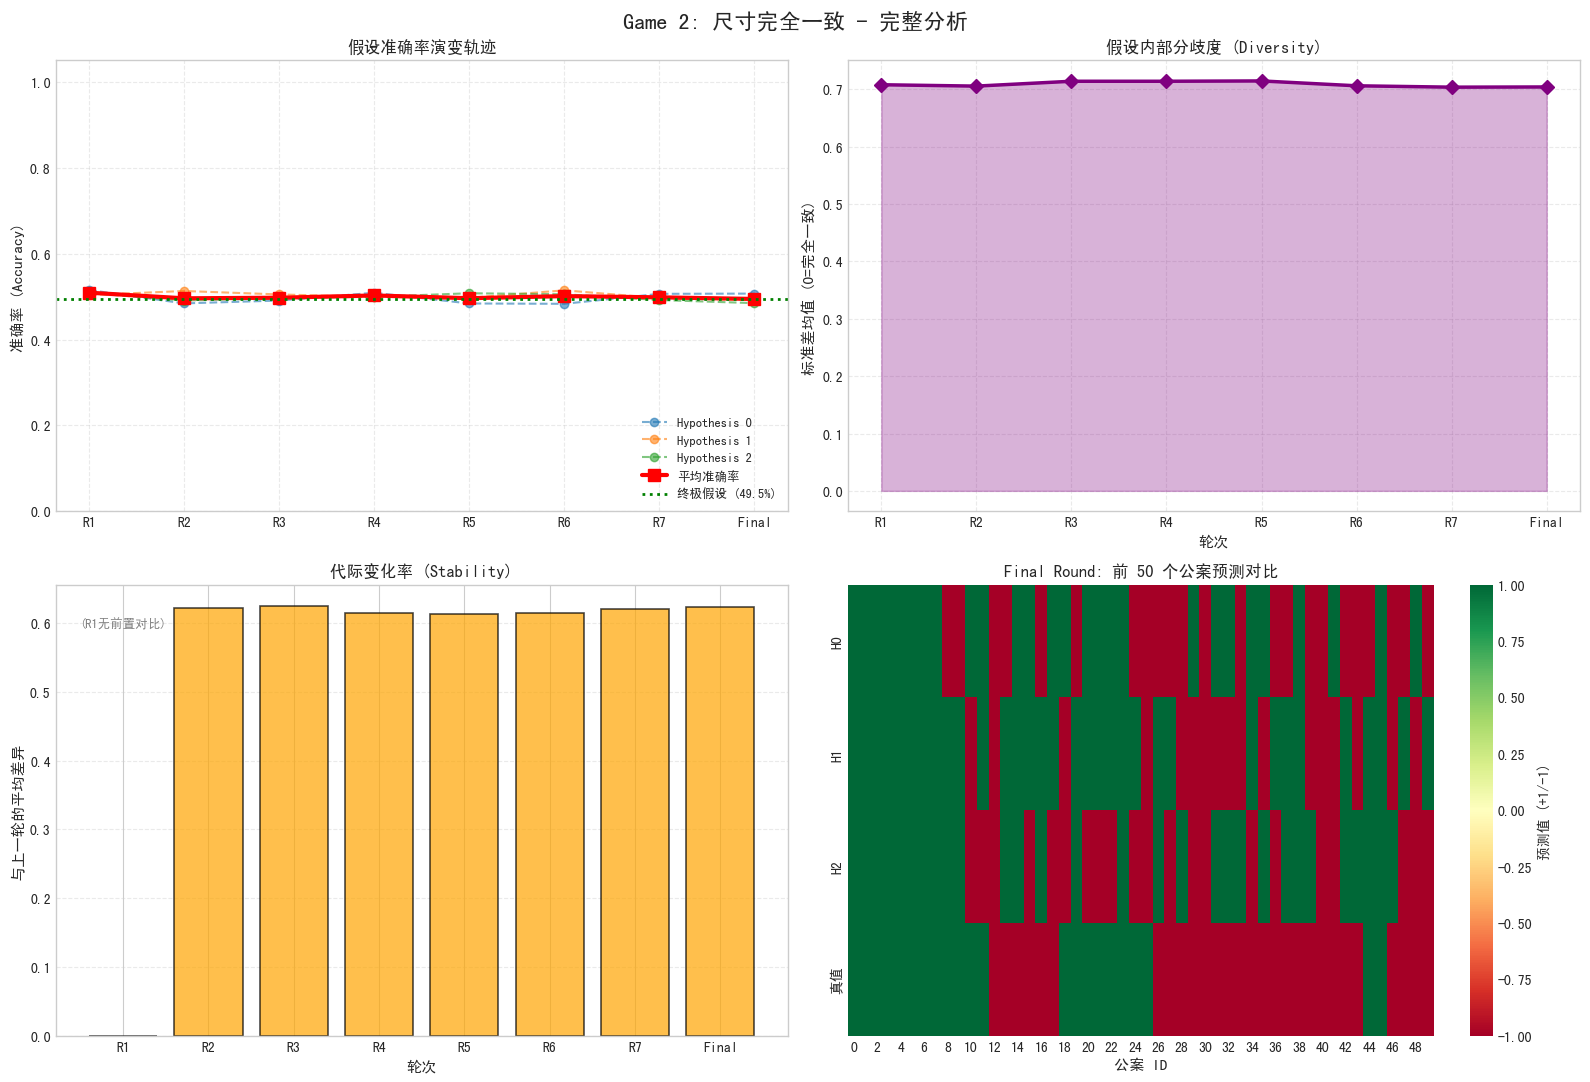

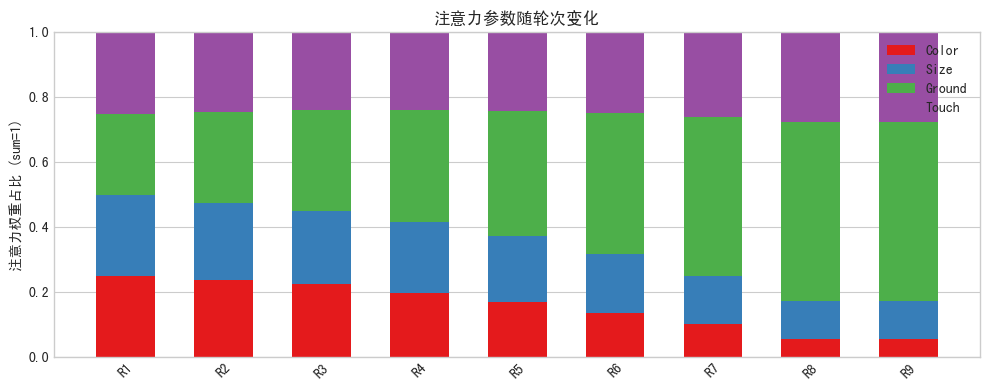

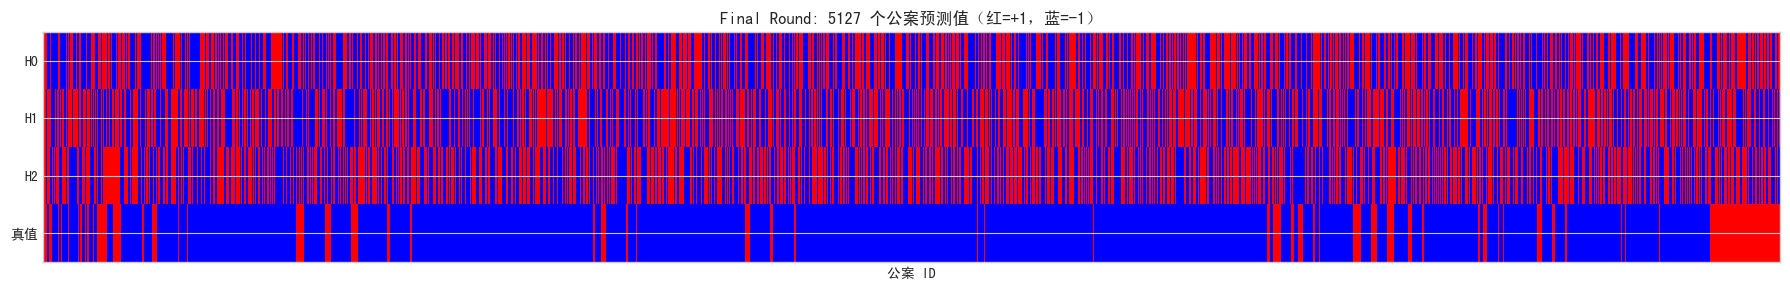

✅ 可视化完成


In [4]:
# ========================================
# 数据分析与可视化
# ========================================

# 计算统计指标
stats = {
    "accuracies": [],
    "diversity": [],
    "stability": [],
    "ultimate_acc": ultimate_acc
}

prev_mean_hyp = None

for idx, r_data in enumerate(rounds_data):
    # A. 准确率
    accs = np.mean(r_data == gt_vector, axis=1)
    stats["accuracies"].append(accs)
    
    # B. 多样性（假设间的分歧度）
    diversity = np.mean(np.std(r_data, axis=0))
    stats["diversity"].append(diversity)
    
    # C. 稳定性（与上一轮的变化）
    curr_mean_hyp = np.mean(r_data, axis=0)
    if prev_mean_hyp is not None:
        change = np.mean(np.abs(curr_mean_hyp - prev_mean_hyp))
        stats["stability"].append(change)
    else:
        stats["stability"].append(0.0)
    
    prev_mean_hyp = curr_mean_hyp

print("📈 统计分析完成，开始绘图...\n")

# ========================================
# 绘制分析图表
# ========================================

fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle(f"Game {GAME_ID}: {rule_name} - 完整分析", fontsize=16, fontweight='bold')

# 1. 准确率演变曲线
ax1 = axes[0, 0]
acc_data = np.array(stats["accuracies"])  # (Rounds, 3)
rounds_idx = range(len(round_labels))

for i in range(3):
    ax1.plot(rounds_idx, acc_data[:, i], marker='o', linestyle='--', 
             alpha=0.6, linewidth=1.5, label=f'Hypothesis {i}')

# 平均准确率
mean_acc = np.mean(acc_data, axis=1)
ax1.plot(rounds_idx, mean_acc, color='red', linewidth=3, 
         marker='s', markersize=8, label='平均准确率')

# 标记终极假设
ax1.axhline(y=stats["ultimate_acc"], color='green', linestyle=':', 
            linewidth=2, label=f'终极假设 ({stats["ultimate_acc"]*100:.1f}%)')

ax1.set_xticks(rounds_idx)
ax1.set_xticklabels(round_labels, rotation=0)
ax1.set_ylabel("准确率 (Accuracy)", fontsize=11)
ax1.set_title("假设准确率演变轨迹", fontsize=12, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)
ax1.set_ylim(0, 1.05)
ax1.grid(True, linestyle='--', alpha=0.4)

# 2. 假设多样性/分歧度
ax2 = axes[0, 1]
ax2.plot(round_labels, stats["diversity"], marker='D', color='purple', 
         linewidth=2.5, markersize=7)
ax2.fill_between(range(len(round_labels)), stats["diversity"], 
                  alpha=0.3, color='purple')
ax2.set_title("假设内部分歧度 (Diversity)", fontsize=12, fontweight='bold')
ax2.set_ylabel("标准差均值 (0=完全一致)", fontsize=11)
ax2.set_xlabel("轮次", fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.4)

# 3. 代际变化率（稳定性）
ax3 = axes[1, 0]
colors_bar = ['gray'] + ['orange'] * (len(stats["stability"]) - 1)
bars = ax3.bar(round_labels, stats["stability"], color=colors_bar, 
                alpha=0.7, edgecolor='black', linewidth=1.2)
ax3.set_title("代际变化率 (Stability)", fontsize=12, fontweight='bold')
ax3.set_ylabel("与上一轮的平均差异", fontsize=11)
ax3.set_xlabel("轮次", fontsize=11)
ax3.text(0, max(stats["stability"]) * 0.95, "(R1无前置对比)", 
         ha='center', fontsize=9, color='gray', style='italic')
ax3.grid(True, axis='y', linestyle='--', alpha=0.4)

# 4. 预测热力图
ax4 = axes[1, 1]
sample_size = 50
heatmap_data = rounds_data[-1][:, :sample_size]  # Final轮的前50个公案
heatmap_data_with_gt = np.vstack([heatmap_data, gt_vector[:sample_size]])

sns.heatmap(heatmap_data_with_gt, ax=ax4, cmap="RdYlGn", center=0,
            cbar_kws={'label': '预测值 (+1/-1)'}, 
            yticklabels=["H0", "H1", "H2", "真值"])
ax4.set_title(f"Final Round: 前 {sample_size} 个公案预测对比", 
              fontsize=12, fontweight='bold')
ax4.set_xlabel("公案 ID", fontsize=11)
ax4.set_ylabel("")

plt.tight_layout()
plt.show()

# === 注意力参数堆叠柱状图 (每轮柱高=1，分成 Color/Size/Ground/Touch) ===
try:
    att = np.array(attention_history)  # (T,4)
    # 归一化每一行，确保每轮柱高为1
    row_sums = att.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    att_norm = att / row_sums
    num_rounds = att_norm.shape[0]
    # 使用已有的 round_labels 作为 x 轴标签（若长度不匹配则生成默认标签）
    if len(round_labels) == num_rounds:
        x_labels = round_labels
    else:
        x_labels = [f'R{i+1}' for i in range(num_rounds)]
    comp_names = ['Color', 'Size', 'Ground', 'Touch']
    comp_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
    fig2, ax2 = plt.subplots(figsize=(10, 4))
    bottom = np.zeros(num_rounds)
    for i in range(4):
        ax2.bar(range(num_rounds), att_norm[:, i], bottom=bottom, color=comp_colors[i], width=0.6, label=comp_names[i])
        bottom += att_norm[:, i]
    ax2.set_ylim(0, 1)
    ax2.set_xticks(range(num_rounds))
    ax2.set_xticklabels(x_labels, rotation=45)
    ax2.set_ylabel('注意力权重占比 (sum=1)')
    ax2.set_title(f'注意力参数随轮次变化')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('⚠️ 无法绘制注意力图：', e)

# === Final Round 全部公案预测可视化（H0/H1/H2 + Ground Truth） ===
try:
    final_stack_full = rounds_data[-1]  # (3, N)
    gt_full = gt_vector  # (N,)
    full_matrix = np.vstack([final_stack_full, gt_full])  # (4, N)
    red = np.array([255, 0, 0], dtype=np.uint8)
    blue = np.array([0, 0, 255], dtype=np.uint8)
    img = np.where(full_matrix[:, :, None] > 0, red, blue)  # (4, N, 3)
    fig3, ax3 = plt.subplots(figsize=(18, 3))
    ax3.imshow(img, aspect='auto', interpolation='nearest')
    ax3.set_yticks([0, 1, 2, 3])
    ax3.set_yticklabels(['H0', 'H1', 'H2', '真值'])
    ax3.set_xlabel('公案 ID')
    ax3.set_title('Final Round: 5127 个公案预测值（红=+1，蓝=-1）')
    ax3.set_xticks([])
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('⚠️ 无法绘制全量预测图：', e)

print("✅ 可视化完成")


### 游戏过程回顾

下表总结了每一轮的检验过程：


In [5]:
# 打印游戏日志表格
import pandas as pd

log_df = pd.DataFrame(game_log)
log_df['avg_accuracy'] = log_df['accuracies'].apply(lambda x: f"{np.mean(x)*100:.1f}%")
log_df['H0_acc'] = log_df['accuracies'].apply(lambda x: f"{x[0]*100:.1f}%")
log_df['H1_acc'] = log_df['accuracies'].apply(lambda x: f"{x[1]*100:.1f}%")
log_df['H2_acc'] = log_df['accuracies'].apply(lambda x: f"{x[2]*100:.1f}%")

display_df = log_df[['round', 'test_koan', 'result', 'H0_acc', 'H1_acc', 'H2_acc', 'avg_accuracy', 'known_pos', 'known_neg']]
display_df.columns = ['轮次', '检验公案', '结果', 'H0准确率', 'H1准确率', 'H2准确率', '平均准确率', '已知正例数', '已知反例数']

print("\n" + "="*100)
print(f"📋 游戏 {GAME_ID} - {rule_name} 检验过程记录")
print("="*100)
print(display_df.to_string(index=False))
print("="*100)
print(f"\n🏆 最终成绩: {ultimate_acc*100:.2f}%")
print(f"📊 总检验次数: {len(game_log)} 轮")
print(f"✅ Pass: {sum(1 for log in game_log if log['result'] == 'Pass')} 次")
print(f"❌ Fail: {sum(1 for log in game_log if log['result'] == 'Fail')} 次")



📋 游戏 2 - 尺寸完全一致 检验过程记录
 轮次  检验公案   结果 H0准确率 H1准确率 H2准确率 平均准确率  已知正例数  已知反例数
  1     1 Pass 51.6% 50.4% 50.8% 50.9%      2      0
  2     0 Pass 48.4% 51.3% 49.1% 49.6%      3      0
  3     2 Pass 49.1% 50.5% 49.6% 49.7%      4      0
  4     3 Pass 50.9% 50.0% 50.0% 50.3%      5      0
  5     4 Pass 48.4% 49.7% 50.8% 49.6%      6      0
  6     6 Pass 48.3% 51.5% 50.6% 50.1%      7      0
  7     5 Pass 50.7% 49.7% 49.2% 49.8%      8      0

🏆 最终成绩: 49.46%
📊 总检验次数: 7 轮
✅ Pass: 7 次
❌ Fail: 0 次


---

## 图表解读指南

### 1. 准确率演变曲线
- **红色粗线（平均准确率）**：应随轮次上升，表示学习有效
- **绿色虚线（终极假设）**：投票后的最终表现
- **三条细线（单个假设）**：
  - 重合 → 多样性丧失（Mode Collapse）
  - 持续低于50% → 陷入局部极小值

### 2. 假设内部分歧度
- **初期高分歧**：健康的探索阶段
- **后期低分歧**：收敛到一致性假设
- **持续为0**：警告！MCMC采样失效

### 3. 代际变化率
- **高柱子**：该轮模型大幅修正假设（通常在收到Fail反馈后）
- **低柱子 + 收到Fail**：确认偏误（模型忽略负面证据）

### 4. 预测热力图
- **颜色一致**：假设与真值吻合
- **颜色对立**：假设出错
- **三行H0/H1/H2颜色差异**：假设间存在分歧

---

## 快速重新运行

要测试其他游戏，只需：
1. 修改第2个Cell中的 `GAME_ID = X`
2. 点击 "Restart Kernel and Run All"
